## Compare Autoencoder Results with the PCA/KPCA method

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
from utils import strip_cross, reconstruct_cross
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
from KPCA import *
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from utils import calc_energy

# from importlib import reload

#### Setup device

In [2]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

### 4roll data

In [6]:

# Prepare the shape of the input for running in the Autoencoder
def np2torch(X):
    Nt = X.shape[1] # number of snapshots
    X_data = X.reshape((-1,5,Nt))
    X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nx, Nc, Nt) -> (Nt, Nc, Nx)

    # convert data
    X_torch = torch.from_numpy(X_data)
    return X_torch

def torch2np(X_torch):
    X_data = X_torch.detach().numpy()
    X_data = np.moveaxis(X_data,[0,2],[2,0]) # (Nt, Nc, Nx) -> (Nx, Nc, Nt)
    Nt = X_data.shape[-1]
    X = X_data.reshape((-1, Nt))
    return X



In [33]:

## Data reading

# Parameters:
Re = 1
Wi = 7.0
beta = 0.3
alpha = (1-beta)/(Re*Wi)

dx = 1/2**6
# type of simulation
case = '4roll'
#read file
X, Xmean = get_data(Re,Wi,beta, case, n_data= -2, dir_path='../npz_data')
print('Data shape: ',X.shape)
# Reshape for pytorch NN
X_torch = np2torch(X)
print('Pytorch Input shape: ',X_torch.shape)



#normalize data inside autoencoder
lower_bound = (X_torch.min(dim = 0, keepdim=True)[0].min(dim=2, keepdim=True)[0]).float().to(device)
upper_bound = (X_torch.max(dim = 0, keepdim=True)[0].max(dim=2, keepdim=True)[0]).float().to(device)

Data shape:  (20480, 3998)
Pytorch Input shape:  torch.Size([3998, 5, 4096])


In [34]:


# NN part
latent_dim = 3
autoencoder = Autoencoder.AutoencoderModule(n_input= X_torch.shape[-1], latent_dim = latent_dim, max_in=upper_bound, min_in=lower_bound).to(device)

autoencoder.load_state_dict(torch.load(f'../Models/Dense_Latent_{latent_dim}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}/best_autoencoder',map_location=torch.device('cpu')))

<All keys matched successfully>

In [35]:
# Run test

X_ae_torch = autoencoder(X_torch.float())
X_ae = torch2np(X_ae_torch)

#### Run PCA/KPCA

In [36]:
degree = 1

# PCA
ncomp = latent_dim
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='linear', gamma=alpha, norm='DIV', eps = None) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_linear = R.T@Q2.T

# KPCA
Qtest, _, _, _ = kpca(X.T, n_components=ncomp, kernel='oldroyd', gamma=alpha, norm='DIV', eps = None, dx = dx, dy = dx) 

Q2 = np.concatenate([np.ones((X.shape[1],1))] + [Qtest**(k+1) for k in range(degree)], axis=1)
R, _, _, _ = np.linalg.lstsq(Q2, X.T, rcond=None)

X_oldroyd = R.T@Q2.T

#### Calc Energy

In [ ]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = dx, dy = dx)
# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = dx, dy = dx)
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = dx, dy = dx)
# Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = dx, dy = dx)

#### Plot Result

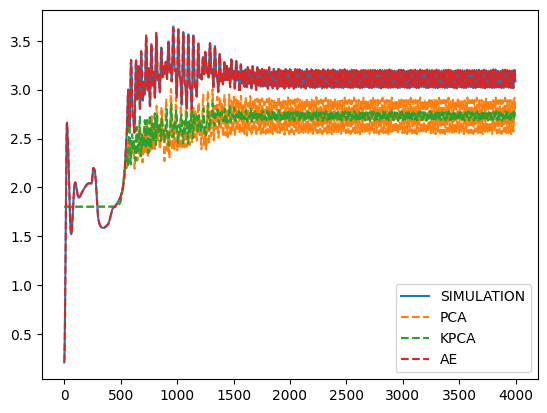

In [ ]:
ini = 0
fim = -1
plt.plot(total[ini:fim], label = 'SIMULATION')
plt.plot(total_linear[ini:fim],'--', label = 'PCA')
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')
plt.plot(total_ae[ini:fim],'--', label = 'AE')
plt.legend()